# Analysis of Washington Post headlines during the COVID-19 pandemic

The Washington Post is the #7 newspaper in the U.S. by circulation. https://en.wikipedia.org/wiki/List_of_newspapers_in_the_United_States#Top_10_newspapers_by_circulation

Digital circulation is more difficult to gauge. The Washington Post is one of the newspapers that have not fully reported their digital circulation to the Alliance for Audited Media (AAM), the group that audits the circulation figures of many of the largest North American newspapers and other publications. https://www.journalism.org/fact-sheet/newspapers/

Nevertheless the Washington Post is a top newspaper in the United States. 

This notebook analyzes how the headlines have evolved since the day the first case appeared in the U.S.

Import libraries.

In [368]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException, NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC
import datetime
import pandas as pd
import time
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy
import gensim
from sklearn.manifold import TSNE
from datetime import timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from timeit import default_timer as timer
import re
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
plt.style.use('dark_background')


## Scrape headlines from the Washington Post

Set date range we are interested in. WHO knew about coronavirus as early as December 8, 2019 (https://en.wikipedia.org/wiki/Coronavirus_disease_2019), so our start date is December 8.

In [59]:
start = datetime.date(2019, 12, 8)
end = datetime.date.today() - timedelta(4)
num_days = (end - start).days 
date_range = pd.date_range(start, periods=num_days).tolist()
date_range_for_plots = [str(x).split(' ')[0] for x in date_range]

In [60]:
print('Range: ' + str(start) + ' to ' + str(end)) # will change this
print('Length: ' + str(num_days) + ' days')
date_range[:10]

Range: 2019-12-08 to 2020-04-12
Length: 126 days


[Timestamp('2019-12-08 00:00:00', freq='D'),
 Timestamp('2019-12-09 00:00:00', freq='D'),
 Timestamp('2019-12-10 00:00:00', freq='D'),
 Timestamp('2019-12-11 00:00:00', freq='D'),
 Timestamp('2019-12-12 00:00:00', freq='D'),
 Timestamp('2019-12-13 00:00:00', freq='D'),
 Timestamp('2019-12-14 00:00:00', freq='D'),
 Timestamp('2019-12-15 00:00:00', freq='D'),
 Timestamp('2019-12-16 00:00:00', freq='D'),
 Timestamp('2019-12-17 00:00:00', freq='D')]

In [61]:
date_range_for_plots[0]

'2019-12-08'

Set Washington Post URLs from the Internet Archive Wayback Machine for 2019 and 2020.

In [16]:
urls = ['https://web.archive.org/web/20190901000000*/washingtonpost.com', 
        'https://web.archive.org/web/*/washingtonpost.com']

For each day in our range, collect headlines from the last snapshot of that day.

In [25]:
browser = webdriver.Chrome(executable_path='./chromedriver') 
browser.maximize_window() 
data = {}

for j in range(0, len(urls)):
    
    # Navigate browser to URL
    browser.get(urls[j])
    
    # Get all date elements on the page
    calendar_grid = WebDriverWait(browser, 20).until(EC.element_to_be_clickable((By.CLASS_NAME, 'calendar-grid')))
    dates = calendar_grid.find_elements_by_tag_name('a')  
    
    if j == 0: # If 2019, we will iterate over dates backward from last one (Dec 31)
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
        time.sleep(5)
        start = len(dates) - 1
        end = 0
        step = -1
    elif j == 1: # If 2020, we will iterate over dates forward from first one (Jan 1)
        start = 0
        end = len(dates) 
        step = 1
    
    # Iterate over dates 
    for i in range(start, end, step):        
        # Hover over the date, let popup appear, wait for loader to disappear, select scroll area
        browser.execute_script("""
            arguments[0].addEventListener('mouseover', function() {
            });
            
            var event = new MouseEvent('mouseover', {
                'view': window,
                'bubbles': true,
                'cancelable': true
            });
            
            arguments[0].dispatchEvent(event);""", dates[i])
        popup = WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.popup-of-day-content')))
        WebDriverWait(browser, 20).until(EC.invisibility_of_element_located((By.TAG_NAME, 'svg')))
        scroll_area = WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.popup-of-day-content > ul > div')))

        # Get date text and check that it is in our range
        date = popup.find_element_by_class_name('day-tooltip-title')
        date_formatted = datetime.datetime.strptime(date.text, '%B %d, %Y')
        print('Date: ' + str(date_formatted))
        if date_formatted not in date_range:
            break # skip if it is not
        else:
            attempts = 0
            while attempts < 5:
                try:
                    browser.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scroll_area)
                    snapshots = popup.find_elements_by_tag_name('a')        
                    last_snapshot = snapshots[len(snapshots) - 1]
                    print('Last snapshot taken at ' + last_snapshot.text)
                    data[date_formatted] = {'link': last_snapshot.get_attribute('href'),
                                            'time': last_snapshot.text,
                                            'headlines': [],
                                            'sections': []}
                    break
                except StaleElementReferenceException:
                    attempts += 1

OSError: [Errno 8] Exec format error: './chromedriver'

View our data so far.

In [31]:
data

NameError: name 'data' is not defined

Scrape headlines from each day link.

In [5]:
unacceptable_headlines = ['', 
                          'More Editors’ Picks',
                          'Listen to Post Reports',
                          'On Tonight’s Podcast',
                          'Here are 15 of the week’s best photos']

In [766]:
def get_section(element):
    try:
        return re.search('washingtonpost.com/([\w-]*)/', element.get_attribute('href'))[1]
    except NoSuchElementException:
        #print('Not a link')
        return None
    except TypeError:
        #print('Not a WashingtonPost link')
        return None
    else: 
        #print('Empty headline or "More Editors\' Picks"')
        return None

browser = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # brew install chromedriver then see in terminal where it was installed to and paste this
data[datetime.datetime(2019, 12, 10, 0, 0)]['link'] = 'https://web.archive.org/web/20191210232000/https://www.washingtonpost.com/'
data[datetime.datetime(2020, 3, 9, 0, 0)]['link'] = 'https://web.archive.org/web/20200309230659/https://www.washingtonpost.com/'
data[datetime.datetime(2020, 2, 5, 0, 0)]['link'] = 'https://web.archive.org/web/20200205224814/https://www.washingtonpost.com/'

for day in data:
    if len(data[day]['headlines']) == 0:
        print('Scraping ' + str(day) + '...')
        headlines = []
        sections = []
        browser.get(data[day]['link'])
        elements = browser.find_elements_by_xpath('//a[@data-pb-field=\'headlines.basic\']')

        for element in elements:
            headline = element.text.strip()
            if headline not in unacceptable_headlines:
                section = get_section(element)
                if section: # if section was found, note section & headline
                    sections.append(section)
                    headlines.append(headline)

        data[day]['sections'] = sections
        data[day]['headlines'] = headlines

        print('Found ' + str(len(headlines)) + ' headlines')
        print('Found ' + str(len(sections)) + ' sections')

        time.sleep(5)

Scraping 2020-02-05 00:00:00...
Found 79 headlines
Found 79 sections


Save to CSV.

In [767]:
df = pd.DataFrame.from_dict(data).T.rename_axis('date').reset_index()
df.to_csv('data.csv', index=False)
df

,date,link,time,headlines,sections
0,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,"[Listen to Post Reports, How black women are f...","[podcasts, podcasts, podcasts, podcasts, world..."
1,2019-12-30,https://web.archive.org/web/20191230234644/was...,23:46:44,"[Listen to Post Reports, A tale of two billion...","[podcasts, podcasts, podcasts, podcasts, busin..."
2,2019-12-29,https://web.archive.org/web/20191229232132/was...,23:21:32,[Giuliani took part in 2018 call with Maduro a...,"[politics, powerpost, nation, nation, entertai..."
3,2019-12-28,https://web.archive.org/web/20191228233354/was...,23:33:54,"[Drug regulators, lawmakers spar over whether ...","[investigations, politics, politics, business,..."
4,2019-12-27,https://web.archive.org/web/20191227235913/was...,23:59:13,"[Listen to Post Reports, The Altamont Concert,...","[podcasts, podcasts, podcasts, podcasts, busin..."
...,...,...,...,...,...
121,2020-04-07,https://web.archive.org/web/20200407223927/was...,22:39:27,[Trump removes inspector general who was to ov...,"[national-security, us-policy, national-securi..."
122,2020-04-08,https://web.archive.org/web/20200408222337/was...,22:23:37,"[Sanders ends White House bid, clears way for ...","[politics, health, local, business, us-policy,..."
123,2020-04-09,https://web.archive.org/web/20200409224804/was...,22:48:04,[Wide swaths of the country are ill-prepared f...,"[graphics, business, national, politics, natio..."
124,2020-04-10,https://web.archive.org/web/20200410094925/was...,09:49:25,[Trump seeks to reopen much of U.S. next month...,"[national, world, national-security, health, h..."


## Load the data

In [2]:
df = pd.read_csv('data.csv', index_col=False, parse_dates=['date'])
df['headlines'] = df['headlines'].apply(literal_eval)
df['sections'] = df['sections'].apply(literal_eval)
df

,date,link,time,headlines,sections
0,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,"[Listen to Post Reports, How black women are f...","[podcasts, podcasts, podcasts, podcasts, world..."
1,2019-12-30,https://web.archive.org/web/20191230234644/was...,23:46:44,"[Listen to Post Reports, A tale of two billion...","[podcasts, podcasts, podcasts, podcasts, busin..."
2,2019-12-29,https://web.archive.org/web/20191229232132/was...,23:21:32,[Giuliani took part in 2018 call with Maduro a...,"[politics, powerpost, nation, nation, entertai..."
3,2019-12-28,https://web.archive.org/web/20191228233354/was...,23:33:54,"[Drug regulators, lawmakers spar over whether ...","[investigations, politics, politics, business,..."
4,2019-12-27,https://web.archive.org/web/20191227235913/was...,23:59:13,"[Listen to Post Reports, The Altamont Concert,...","[podcasts, podcasts, podcasts, podcasts, busin..."
...,...,...,...,...,...
121,2020-04-07,https://web.archive.org/web/20200407223927/was...,22:39:27,[Trump removes inspector general who was to ov...,"[national-security, us-policy, national-securi..."
122,2020-04-08,https://web.archive.org/web/20200408222337/was...,22:23:37,"[Sanders ends White House bid, clears way for ...","[politics, health, local, business, us-policy,..."
123,2020-04-09,https://web.archive.org/web/20200409224804/was...,22:48:04,[Wide swaths of the country are ill-prepared f...,"[graphics, business, national, politics, natio..."
124,2020-04-10,https://web.archive.org/web/20200410094925/was...,09:49:25,[Trump seeks to reopen much of U.S. next month...,"[national, world, national-security, health, h..."


Make a row for each headline + section.

In [6]:
df_headsects = pd.DataFrame({
    col: np.repeat(df[col].values, df['headlines'].str.len())
    for col in df.columns.drop(['headlines', 'sections'])}
).assign(**{'headline': np.concatenate(df['headlines'].values), 
            'section': np.concatenate(df['sections'].values)})

df_headsects

,date,link,time,headline,section
0,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Listen to Post Reports,podcasts
1,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,How black women are fighting for — and winning...,podcasts
2,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,On Tonight’s Podcast,podcasts
3,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Listen to Post Reports,podcasts
4,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Militia supporters chanting ‘Death to America’...,world
...,...,...,...,...,...
10154,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,Undocumented workers among those hit first — a...,business
10155,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Pat Stapleton, all-star defenseman for Chicago...",local
10156,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Darran Simon, Washington Post journalist, dies...",local
10157,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Mort Drucker, Mad magazine artist who drew hum...",local


Delete any headlines and sections that are not really headlines. I updated the code above to account for this before they are saved. Can delete this if we rerun the above code for extracting headlines and sections and it works.

In [7]:
df_headsects = df_headsects[~df_headsects['headline'].isin(unacceptable_headlines)]
len(df_headsects)

9939

Delete any headlines that are duplicates. Som

In [8]:
df_headsects[df_headsects.duplicated()]

,date,link,time,headline,section
912,2019-12-20,https://web.archive.org/web/20191220233157/was...,23:31:57,How we know global warming is real,graphics
6883,2020-03-03,https://web.archive.org/web/20200303235037/was...,23:50:37,Where the candidates traveled in their final p...,politics
8089,2020-03-18,https://web.archive.org/web/20200318232205/was...,23:22:05,Mapping the spread of the coronavirus in the U...,graphics
9337,2020-04-02,https://web.archive.org/web/20200402233352/was...,23:33:52,How coronavirus grounded the airline industry,graphics


In [9]:
df_headsects_unique = df_headsects.drop_duplicates(subset='headline', keep='first')
df_headsects_unique

,date,link,time,headline,section
1,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,How black women are fighting for — and winning...,podcasts
4,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Militia supporters chanting ‘Death to America’...,world
5,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Retropolis: ‘Death to America’ chants heard in...,history
6,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,"Trump threatens Iran after embassy attack, but...",politics
7,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Why Iraq is at the center of the dispute betwe...,world
...,...,...,...,...,...
10153,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,‘Screen time’ has gone from sin to survival tool,technology
10154,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,Undocumented workers among those hit first — a...,business
10155,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Pat Stapleton, all-star defenseman for Chicago...",local
10156,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Darran Simon, Washington Post journalist, dies...",local


Group headlines by day, week, month.

In [507]:
series = pd.Series(list(df_headsects['headline']), index=list(df_headsects['date']))
daily_headlines = series.resample('D').apply(lambda x: list(x))
weekly_headlines = series.resample('W-MON').apply(lambda x: list(x))
monthly_headlines = series.resample('M').apply(lambda x: list(x))

series = pd.Series(list(df_headsects['section']), index=list(df_headsects['date']))
daily_sections = series.resample('D').apply(lambda x: list(x))
weekly_sections = series.resample('W-MON').apply(lambda x: list(x))
monthly_sections = series.resample('M').apply(lambda x: list(x))

In [269]:
daily_headlines

2019-12-08    [FBI is investigating Pensacola attack as an a...
2019-12-09    [U.S. officials misled public about Afghan war...
2019-12-10    [Obstruction, abuse of power: What the article...
2019-12-11    [Why Washington is still fighting about the or...
2019-12-12    [Who’s losing out in the automated economy? Wo...
                                    ...                        
2020-04-07    [Trump removes inspector general who was to ov...
2020-04-08    [Sanders ends White House bid, clears way for ...
2020-04-09    [Wide swaths of the country are ill-prepared f...
2020-04-10    [Trump seeks to reopen much of U.S. next month...
2020-04-11    [U.S. surpasses Italy for most covid-19 deaths...
Length: 126, dtype: object

In [273]:
len(daily_headlines[0]) == len(df_headsects[df_headsects['date'] == datetime.datetime(2019, 12, 8)]['headline'])

True

In [275]:
weekly_headlines

2019-12-09    [FBI is investigating Pensacola attack as an a...
2019-12-16    [Obstruction, abuse of power: What the article...
2019-12-23    [‘Our time there ended up being worthless’: Vo...
2019-12-30    [The troubling ethics of fashion in the age of...
2020-01-06    [How black women are fighting for — and winnin...
2020-01-13    [What’s holding up the Senate impeachment tria...
2020-01-20    [‘No financial boundaries’: Bloomberg’s campai...
2020-01-27    [House managers, Trump’s legal team spar over ...
2020-02-03    [Trump defense team finishes opening arguments...
2020-02-10    [Sanders, Buttigieg leading in early results, ...
2020-02-17    [How the CIA tricked allies and enemies into s...
2020-02-24    [Allegations of Mike Bloomberg’s profanity and...
2020-03-02    [A faulty CDC coronavirus test delays monitori...
2020-03-09    [First polls closing soon on most consequentia...
2020-03-16    [Dow ends volatile day up more than 1,100 poin...
2020-03-23    [Virus now in all 50 state

In [276]:
len(weekly_headlines[0])

154

In [278]:
monthly_headlines

2019-12-31    [FBI is investigating Pensacola attack as an a...
2020-01-31    [Supporters of Iranian-backed militia end sieg...
2020-02-29    [Justice Dept. acknowledges 24 emails reveal T...
2020-03-31    [What’s so important about Super Tuesday?, Her...
2020-04-30    [Protective gear in national stockpile is near...
dtype: object

In [316]:
[date_obj.strftime('%Y %b %d') for date_obj in weekly_headlines.keys()]

['2019 Dec 09',
 '2019 Dec 16',
 '2019 Dec 23',
 '2019 Dec 30',
 '2020 Jan 06',
 '2020 Jan 13',
 '2020 Jan 20',
 '2020 Jan 27',
 '2020 Feb 03',
 '2020 Feb 10',
 '2020 Feb 17',
 '2020 Feb 24',
 '2020 Mar 02',
 '2020 Mar 09',
 '2020 Mar 16',
 '2020 Mar 23',
 '2020 Mar 30',
 '2020 Apr 06',
 '2020 Apr 13']

## Explore headlines

Top 10 most commonly appearing headlines overall:

In [37]:
df_headsects['headline'].value_counts().head(10)

Guide to the pandemic                                                                     29
Lives adrift in a rapidly warming world: A photographic portrait                          22
Art With a Point: Illustrations from the Post Magazine                                    21
Mapping the spread of the new coronavirus                                                 20
How epidemics like covid-19 end (and how to end them faster)                              18
Mapping the spread of the coronavirus in the U.S. and worldwide                           16
Scenes from Australia’s deadly bush fire crisis                                           15
The new sick leave law doesn’t help the workers that need it most                         13
Trump ramps up border-wall construction ahead of 2020 vote                                12
America’s schools are more diverse than ever. But the teachers are still mostly white.    11
Name: headline, dtype: int64

Top 3 most commonly appearing headlines every week. As expected, they slant toward coronavirus as time passes. Eventually the most headlines that appear every day are from only coronavirus articles. 

In [287]:
[pd.Series(x).value_counts().head(3) for x in weekly_headlines]

[Uber CEO Q&A: When rape happens in an Uber, who’s responsible?      2
 Here are 14 of the week’s best photos                               2
 Lives adrift in a rapidly warming world: A photographic portrait    2
 dtype: int64,
 Lives adrift in a rapidly warming world: A photographic portrait             7
 The five best lightsaber battles in Star Wars history                        6
 At the Kennedy Center, soprano Michelle Bradley navigates risk and reward    4
 dtype: int64,
 Lives adrift in a rapidly warming world: A photographic portrait    7
 How we know global warming is real                                  6
 NSO presents a muddled ‘Messiah,’ but all is not lost               4
 dtype: int64,
 One aria sums up a joyful Washington Bach Consort ‘Christmas Oratorio’    7
 Who America mourned: Flags at half-staff in 2019                          6
 11 trends that changed the way we read this decade                        6
 dtype: int64,
 America’s schools are more diverse than ev

How many headlines each day?

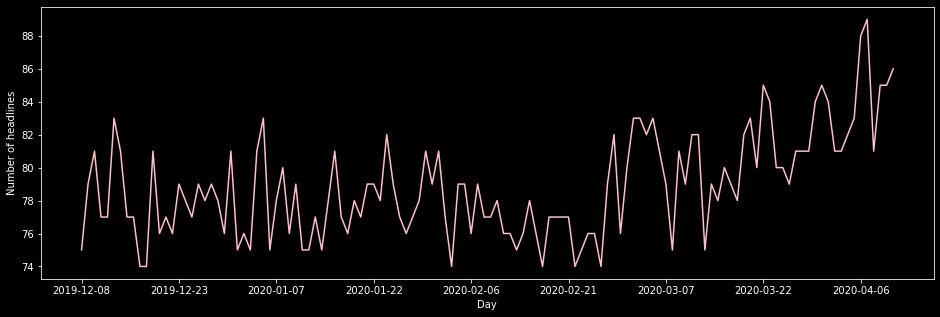

In [372]:
daily_headline_count = [len(x) for x in daily_headlines]
plt.figure(figsize=(16, 5))
plt.xticks(np.arange(0, len(date_range_for_plots), 15))
plt.ylabel('Number of headlines')
plt.xlabel('Day')
plt.plot(date_range_for_plots, daily_headline_count, color='pink')
plt.show()

How many headlines each week? Removed first and last weeks since they are incomplete.

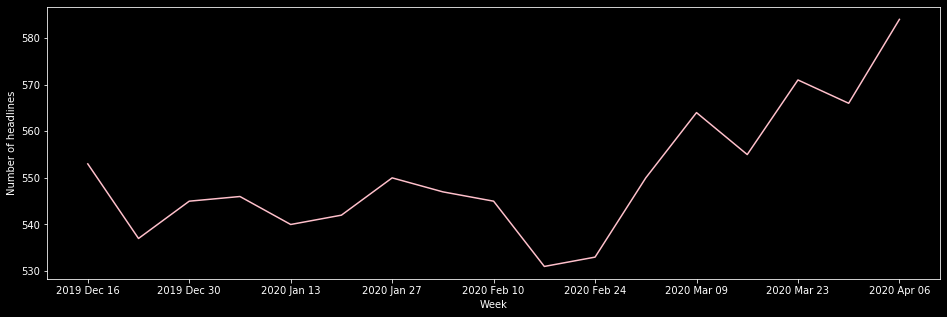

In [371]:
weekly_headline_count = [len(x) for x in weekly_headlines[1:-1]]
plt.figure(figsize=(16, 5))
x = [date_obj.strftime('%Y %b %d') for date_obj in weekly_headlines.keys()[1:-1]]
plt.xticks(np.arange(0, len(x), 2))
plt.ylabel('Number of headlines')
plt.xlabel('Week')
plt.plot(x, weekly_headline_count, color='pink')
plt.show()

How many times does coronavirus appear in the headlines, per day?

First, we will make a list of the words we consider equivalent to coronavirus.

In [593]:
def contains_coronavirus(headline):
    '''Returns boolean.'''
    coronavirus = ['coronavirus', 'covid19', 'covid-19', 'sars-cov-2', 'sarscov2', 'sars-cov2']
    if any(substr in headline.lower() for substr in coronavirus):
        return True
    else:
        return False

df_headsects['contains_coronavirus'] = df_headsects['headline'].apply(contains_coronavirus)
df_headsects

/home/bkh4324/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,date,link,time,headline,section,contains_coronavirus
1,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,How black women are fighting for — and winning...,podcasts,False
4,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Militia supporters chanting ‘Death to America’...,world,False
5,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Retropolis: ‘Death to America’ chants heard in...,history,False
6,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,"Trump threatens Iran after embassy attack, but...",politics,False
7,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,Why Iraq is at the center of the dispute betwe...,world,False
...,...,...,...,...,...,...
10154,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,Undocumented workers among those hit first — a...,business,True
10155,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Pat Stapleton, all-star defenseman for Chicago...",local,False
10156,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Darran Simon, Washington Post journalist, dies...",local,False
10157,2020-04-11,https://web.archive.org/web/20200411175428/was...,17:54:28,"Mort Drucker, Mad magazine artist who drew hum...",local,False


In [557]:
def count_coronavirus(string):
    coronavirus = ['coronavirus', 'covid19', 'covid-19', 'sars-cov-2', 'sarscov2', 'sars-cov2']
    counts = len([s for s in string if any(substr in s.lower() for substr in coronavirus)])
    return counts

In [559]:
appearances = [count_coronavirus(x) for x in daily_headlines]
appearances

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 5,
 6,
 6,
 8,
 6,
 3,
 6,
 6,
 10,
 6,
 7,
 4,
 6,
 5,
 5,
 4,
 4,
 2,
 3,
 4,
 5,
 4,
 3,
 3,
 5,
 4,
 6,
 7,
 6,
 6,
 7,
 5,
 7,
 13,
 11,
 14,
 19,
 13,
 10,
 12,
 14,
 14,
 8,
 16,
 17,
 15,
 24,
 28,
 30,
 35,
 30,
 32,
 30,
 27,
 34,
 28,
 34,
 29,
 23,
 26,
 24,
 28,
 32,
 28,
 25,
 25,
 15,
 17,
 21,
 23,
 30,
 20,
 15,
 27,
 26,
 20,
 29,
 22,
 22,
 18]

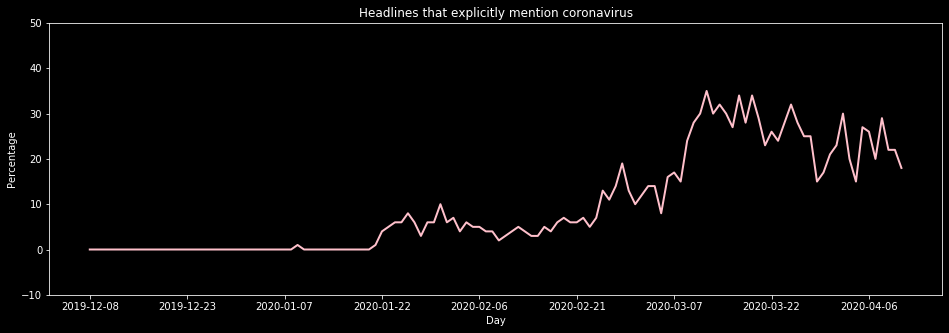

In [494]:
plt.figure(figsize=(16, 5))
plt.ylim(-10, 50)
plt.xticks(np.arange(0, len(date_range_for_plots), 15))
plt.ylabel('Percentage')
plt.xlabel('Day')
plt.title('Headlines that explicitly mention coronavirus')
plt.plot(date_range_for_plots, appearances, color='pink', lw=2)
plt.show()

What was that first headline near January 7th?

In [622]:
date_of_first_headline = date_range[next((i for i, x in enumerate(appearances) if x), None)]
print('Date: ' + str(date_of_first_headline))
print('Headline: ' + [s for s in daily_headlines[date_of_first_headline] if any(substr in s.lower() for substr in coronavirus)][0])
print('Section: ' + [daily_sections[date_of_first_headline][i] for i, s in enumerate(daily_headlines[date_of_first_headline]) if any(substr in s.lower() for substr in coronavirus)][0])


Date: 2020-01-09 00:00:00
Headline: China identifies new strain of coronavirus as source of pneumonia outbreak
Section: world


## Word distributions

**Headline word length**.

First import stopwords. We don't want to consider words such as "the," "an," etc. 

In [497]:
stop_words = set(stopwords.words('english'))

In [498]:
headline_lengths = [len(x.split(' ')) for x in df_headsects_unique['headline']]
headline_lengths

[14,
 13,
 13,
 15,
 15,
 16,
 14,
 15,
 7,
 8,
 11,
 10,
 9,
 11,
 9,
 13,
 12,
 10,
 13,
 10,
 15,
 8,
 9,
 12,
 16,
 6,
 6,
 15,
 14,
 14,
 5,
 11,
 5,
 15,
 8,
 11,
 15,
 11,
 17,
 14,
 13,
 14,
 15,
 14,
 18,
 15,
 13,
 14,
 12,
 11,
 8,
 13,
 9,
 13,
 9,
 6,
 14,
 11,
 12,
 13,
 11,
 10,
 7,
 9,
 9,
 11,
 7,
 13,
 13,
 14,
 13,
 14,
 14,
 19,
 9,
 8,
 12,
 12,
 11,
 13,
 12,
 10,
 10,
 11,
 12,
 13,
 12,
 15,
 12,
 6,
 15,
 12,
 8,
 16,
 14,
 17,
 19,
 10,
 18,
 13,
 16,
 13,
 17,
 15,
 12,
 7,
 11,
 11,
 11,
 5,
 13,
 14,
 13,
 25,
 8,
 8,
 5,
 7,
 7,
 11,
 14,
 9,
 11,
 14,
 14,
 16,
 12,
 14,
 10,
 12,
 12,
 12,
 10,
 11,
 11,
 20,
 14,
 5,
 15,
 12,
 10,
 18,
 15,
 13,
 8,
 15,
 12,
 9,
 7,
 10,
 13,
 4,
 11,
 14,
 13,
 11,
 6,
 15,
 17,
 6,
 13,
 11,
 13,
 11,
 9,
 8,
 8,
 10,
 12,
 10,
 11,
 16,
 14,
 11,
 16,
 19,
 6,
 15,
 15,
 12,
 20,
 10,
 14,
 5,
 9,
 5,
 12,
 10,
 14,
 11,
 12,
 17,
 10,
 16,
 15,
 14,
 14,
 9,
 13,
 12,
 9,
 19,
 13,
 11,
 17,
 16,
 12,
 16,
 12,
 1

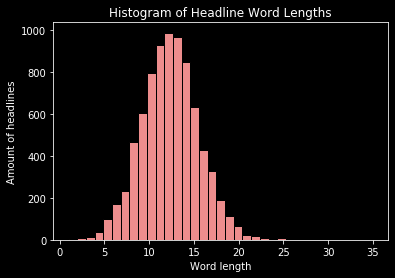

In [499]:
plt.hist(headline_lengths, color='#ed8d8d', edgecolor='black', bins=35)
plt.title('Histogram of Headline Word Lengths')
plt.xlabel('Word length')
plt.ylabel('Amount of headlines')
plt.show()

Most headlines are 12 words in length. 

In [500]:
scipy.mode(headline_lengths).mode[0]

12

Most frequently used words overall. Includes duplicates because these headlines ARE still on the front page.

In [501]:
words = ' '.join([re.sub(r'[,?:.-]', '', headline) for headline in df_headsects['headline']]).split(' ')
words = [word.lower() for word in words if word.lower() not in stop_words and word.strip() != '' and word != '—']
print('Words: ' + str(len(words)))
words

Words: 81234


['black',
 'women',
 'fighting',
 'winning',
 'space',
 'bookshelf',
 'militia',
 'supporters',
 'chanting',
 '‘death',
 'america’',
 'break',
 'us',
 'embassy',
 'compound',
 'baghdad',
 'retropolis',
 '‘death',
 'america’',
 'chants',
 'heard',
 'baghdad',
 'echo',
 'iran',
 'hostage',
 'crisis',
 'trump',
 'threatens',
 'iran',
 'embassy',
 'attack',
 'reluctant',
 'get',
 'involved',
 'region',
 'iraq',
 'center',
 'dispute',
 'iran',
 'united',
 'states',
 'trump',
 'organization',
 'fires',
 'undocumented',
 'workers',
 'year',
 'use',
 'illegal',
 'labor',
 'revealed',
 'epa',
 'advisory',
 'board',
 'dominated',
 'trump',
 'appointees',
 'warns',
 'regulatory',
 'rollbacks',
 'clash',
 'established',
 'science',
 'calendar',
 'says',
 'we’re',
 'moving',
 '2010s',
 'sure',
 'doesn’t',
 'feel',
 'way',
 'good',
 'news',
 'happened',
 '2019',
 'iran',
 'outplayed',
 'united',
 'states',
 'dwyane',
 'wade',
 'gabrielle',
 'union’s',
 'simple',
 'openarmed',
 'act',
 'parental',
 '

In [502]:
pd.Series(words).value_counts()[:25]

coronavirus    1129
trump           744
us              575
new             563
dies            559
trump’s         309
says            259
one             246
it’s            190
say             187
house           180
could           173
dc              172
democrats       171
pandemic        169
impeachment     163
best            155
help            154
like            145
world           143
make            142
need            141
white           141
2020            140
first           139
dtype: int64

Most frequently used word, daily.

In [503]:
top_word_daily = []

for headlines in daily_headlines:
    daily_words = ' '.join([re.sub(r'[,?:.-]', '', headline) for headline in headlines]).split(' ')
    daily_words = [word.lower() for word in daily_words if word.lower() not in stop_words and word.strip() != '' and word != '—']
    daily_counts = pd.Series(daily_words).value_counts(ascending=False)
    top_word_daily.append(daily_counts.keys()[0])

In [504]:
top_words = pd.DataFrame({'date': date_range, 'word': top_word_daily})
top_words

,date,word
0,2019-12-08,impeachment
1,2019-12-09,trump
2,2019-12-10,new
3,2019-12-11,trump
4,2019-12-12,trump
5,2019-12-13,trump
6,2019-12-14,trump
7,2019-12-15,new
8,2019-12-16,trump
9,2019-12-17,new


In [447]:
top_words['word'].value_counts()

coronavirus    50
trump          33
new            12
2019            5
dies            5
us              3
impeachment     2
nevada          2
iowa            2
iran            2
christmas       2
says            1
kobe            1
bloomberg       1
one             1
democrats       1
trump’s         1
need            1
soleimani       1
Name: word, dtype: int64

## Explore sections

Top 10 most populous sections, overall. Not unique headlines but just all the headlines.

In [609]:
top_20_sects = df_headsects['section'].value_counts().head(20)
top_20_sects

local                 1094
politics               915
world                  776
opinions               720
lifestyle              635
business               635
sports                 609
graphics               556
outlook                542
entertainment          486
health                 407
technology             334
news                   311
nation                 252
video-games            205
national               164
science                156
photography            128
arts-entertainment     117
national-security      110
Name: section, dtype: int64

Did the number of articles change over time in each section? Probably not because there are fixed section cards and they want to vary the sections. 

Change this to percentage of headlines that day?

Only health section sees a significant increase.

In [514]:
daily_section_counts = [pd.Series(x).value_counts() for x in daily_sections]
daily_section_counts[-1]

lifestyle             9
local                 7
business              6
opinions              6
graphics              6
world                 5
politics              5
health                5
national              5
outlook               4
sports                4
technology            4
video-games           3
news                  3
entertainment         2
nation                2
coronavirus           2
weather               2
photography           1
us-policy             1
national-security     1
podcasts              1
arts-entertainment    1
immigration           1
dtype: int64

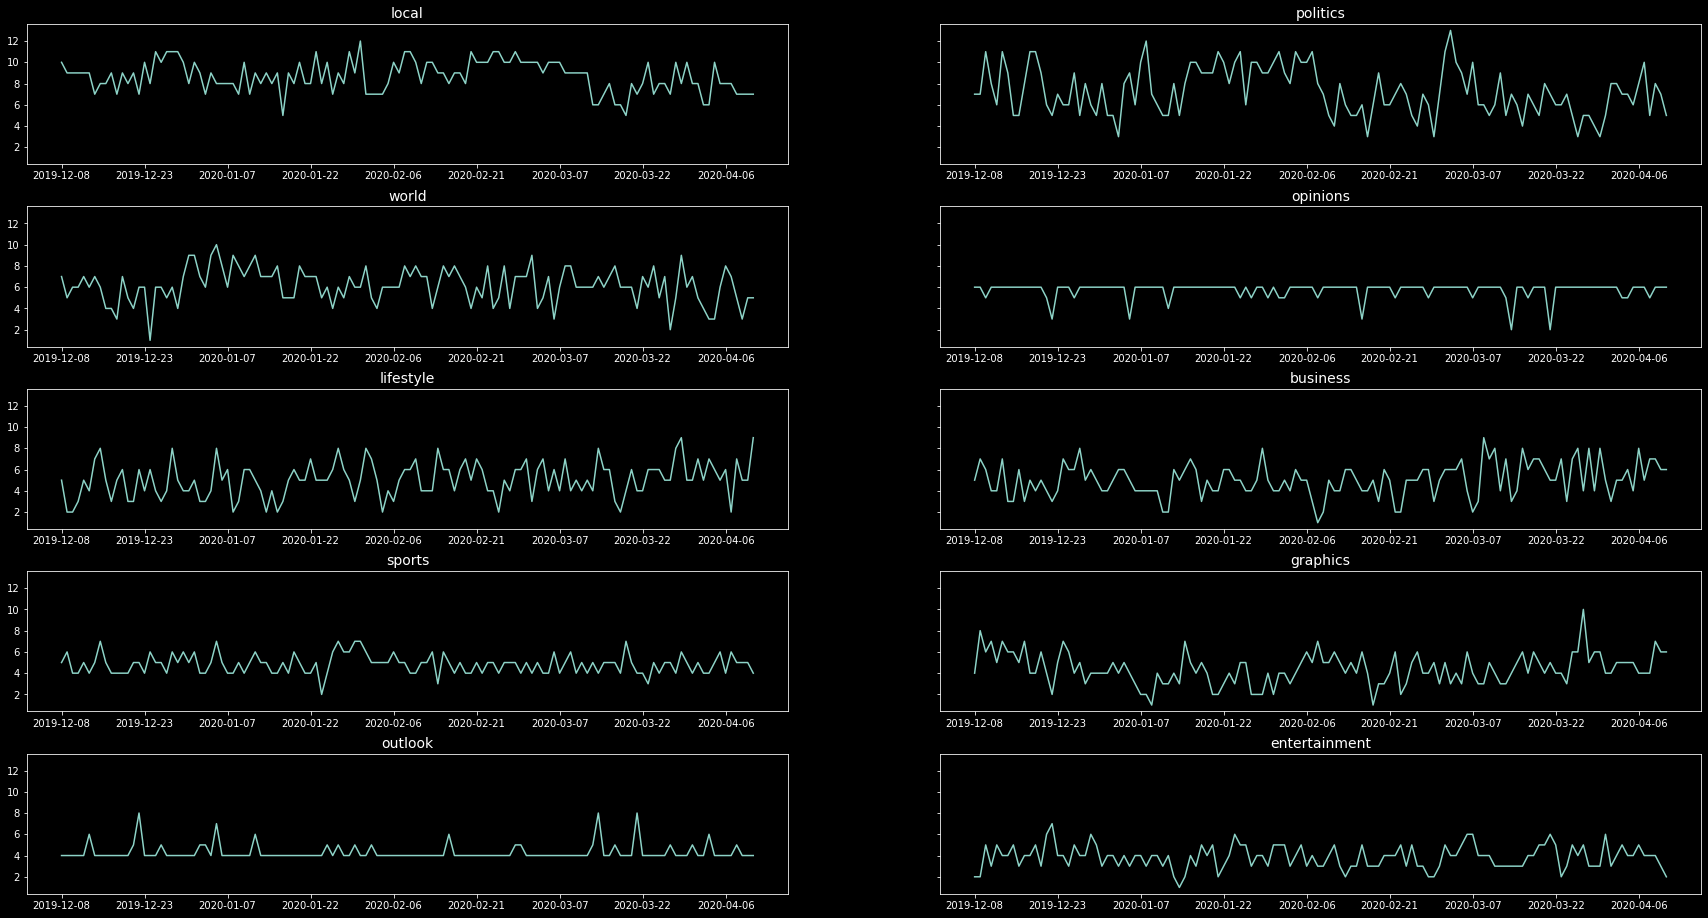

In [528]:
counts = []
names = []
for sect in top_10_sects.keys():
    counts.append([x[sect] if sect in x.keys() else 0 for x in daily_section_counts])
    names.append(sect)
    
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(30, 16), sharey=True)
fig.subplots_adjust(hspace=.3)

for i, ax in enumerate(axarr.reshape(-1)):
    ax.set_title(names[i], fontsize=14)
    ax.set_xticks(np.arange(0, len(date_range_for_plots), 15))
    ax.plot(date_range_for_plots, counts[i])

How many times did each section explicitly mention coronavirus each day? Based on the code above for how many headlines every day mention coronavirus.

In [610]:
top_20_sects

local                 1094
politics               915
world                  776
opinions               720
lifestyle              635
business               635
sports                 609
graphics               556
outlook                542
entertainment          486
health                 407
technology             334
news                   311
nation                 252
video-games            205
national               164
science                156
photography            128
arts-entertainment     117
national-security      110
Name: section, dtype: int64

In [612]:
section_appearances = {top_20_sects.keys()[i]: np.zeros(len(date_range)) for i in range(0, len(top_20_sects.keys()))}


# For each day
for i, headlines in enumerate(daily_headlines):
    sections = daily_sections[i] 
    num_headlines = len(headlines)
    # For each headline,
    for j, headline in enumerate(headlines):
        if contains_coronavirus(headline):
            # If it does, check if its corresponding section is in the top 10
            section = sections[j]
            if section in top_20_sects.keys():
                section_appearances[section][i] += 1 # Increment the section appearance count for the day
            
    #section_appearances[section].append((appears/num_headlines) * 100) # percentage    
section_appearances

{'local': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 2., 1., 3., 3., 2., 2., 0., 1., 0., 0., 1., 2.,
        1., 2., 1., 2., 1., 2., 2., 4., 2., 2., 1., 4., 2., 3., 4., 4., 3.,
        4., 2., 4., 3., 3., 1., 0.]),
 'politics': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 1

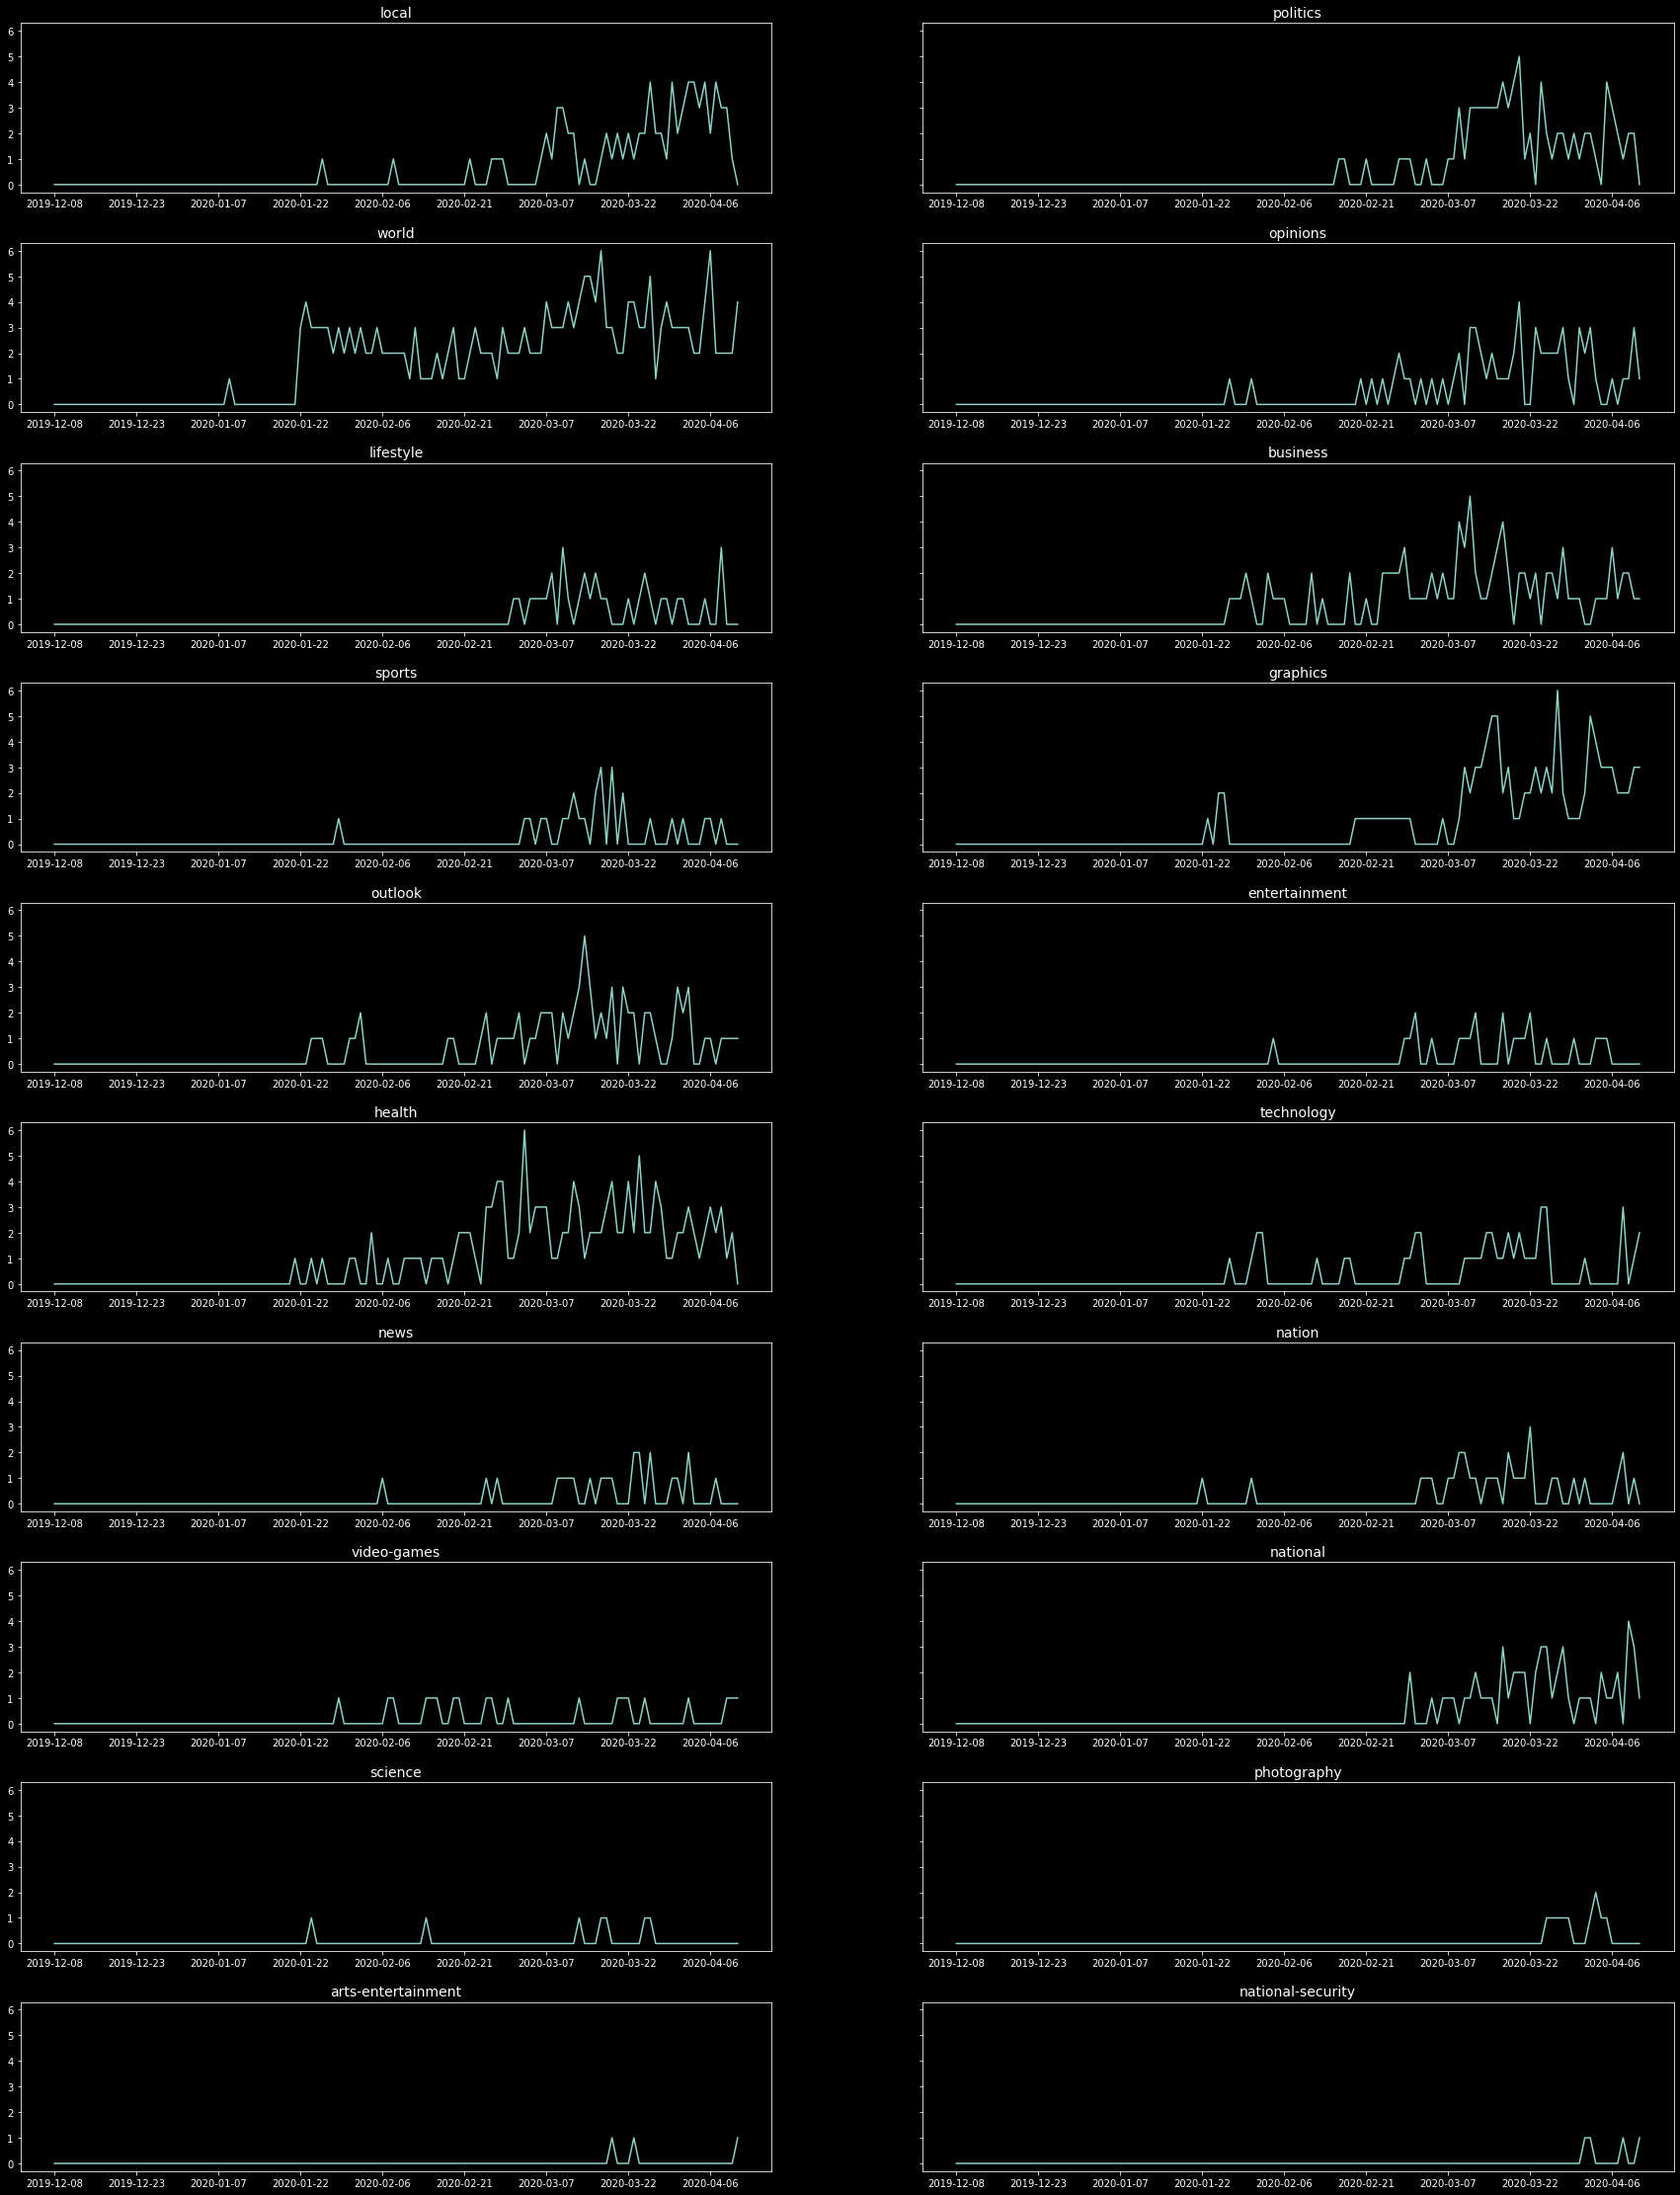

In [618]:
fig, axarr = plt.subplots(nrows=10, ncols=2, figsize=(30, 40), sharey=True)
fig.subplots_adjust(hspace=.3)

for i, ax in enumerate(axarr.reshape(-1)):
    section = top_20_sects.keys()[i]
    ax.set_title(section, fontsize=14)
    ax.set_xticks(np.arange(0, len(date_range_for_plots), 15))
    ax.plot(date_range_for_plots, section_appearances[section])

What day did each section first mention coronavirus on the front page?

In [623]:
for section in section_appearances:
    first_day = next((i for i, x in enumerate(section_appearances[section]) if x), None)
    print(section + ': ' + str(date_range[first_day]))
    
    # What article was that?
    # Need to fix both headlines and sections code together. 

local: 2020-01-26 00:00:00
politics: 2020-02-16 00:00:00
world: 2020-01-09 00:00:00
opinions: 2020-01-27 00:00:00
lifestyle: 2020-03-01 00:00:00
business: 2020-01-27 00:00:00
sports: 2020-01-29 00:00:00
graphics: 2020-01-23 00:00:00
outlook: 2020-01-24 00:00:00
entertainment: 2020-02-04 00:00:00
health: 2020-01-21 00:00:00
technology: 2020-01-27 00:00:00
news: 2020-02-06 00:00:00
nation: 2020-01-22 00:00:00
video-games: 2020-01-29 00:00:00
national: 2020-02-29 00:00:00
science: 2020-01-24 00:00:00
photography: 2020-03-25 00:00:00
arts-entertainment: 2020-03-19 00:00:00
national-security: 2020-04-01 00:00:00


Which sections mention coronavirus the most? (Make bar graph).

In [624]:
for section in section_appearances:
    total = section_appearances[section].sum()
    print(section + ': ' + str(int(total)))

local: 81
politics: 84
world: 218
opinions: 67
lifestyle: 33
business: 97
sports: 27
graphics: 107
outlook: 76
entertainment: 23
health: 136
technology: 46
news: 22
nation: 32
video-games: 20
national: 55
science: 7
photography: 10
arts-entertainment: 3
national-security: 4


## Sentiment analysis

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [3]:
sia = SIA()

In [4]:
results = []

for line in all_headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
    
results

NameError: name 'all_headlines' is not defined

## word2vec

**Load pre-trained word2vec model**

Since this is a news dataset, we use the Google News model, which was trained on about 100 billion words. Download it here. https://code.google.com/archive/p/word2vec/

Other models: https://github.com/RaRe-Technologies/gensim-data

In [944]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

INFO:gensim.models.utils_any2vec:loading projection weights from GoogleNews-vectors-negative300.bin
INFO:gensim.models.utils_any2vec:loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


Check how many dimensions each word vector has.

In [945]:
model.vector_size

300

word2vec can't create a vector from a word that's not in its vocabulary. Because of this, we need to specify "if word in model.vocab" when creating the full list of word vectors.

Check that the model at least has coronavirus.

In [946]:
model['coronavirus']

array([-0.45507812,  0.06787109,  0.08496094,  0.12402344, -0.27929688,
       -0.20800781, -0.0133667 , -0.01672363,  0.38867188,  0.33984375,
        0.6640625 , -0.46679688,  0.26757812, -0.01373291, -0.68359375,
        0.4609375 , -0.20703125,  0.44140625,  0.09521484, -0.24707031,
        0.20800781, -0.36523438,  0.04272461, -0.15039062, -0.02624512,
        0.05053711, -0.10986328, -0.41796875,  0.40039062,  0.06079102,
       -0.51953125, -0.58984375,  0.734375  , -0.12890625,  0.01544189,
        0.13476562, -0.328125  ,  0.17089844,  0.42773438,  0.52734375,
       -0.01953125, -0.3828125 , -0.58984375,  0.63671875,  0.05151367,
       -0.37109375,  0.21484375,  0.1875    , -0.22949219,  0.31054688,
       -0.04882812, -0.21679688, -0.11523438, -0.13769531, -0.234375  ,
        0.44140625, -0.22460938,  0.21875   ,  0.10107422,  0.23535156,
        0.15136719,  0.49609375, -0.14355469,  0.12011719,  0.11474609,
       -0.37109375,  0.1953125 , -0.32226562, -0.20996094,  0.77

In [947]:
vector_list = [model[word] for word in words if word in model.vocab]
len(vector_list)

57871

Create a list of the words corresponding to these vectors

In [948]:
words_filtered = [word for word in words if word in model.vocab]
len(words_filtered)

57871

Zip the words together with their vector representations

In [949]:
word_vec_zip = zip(words_filtered, vector_list)
word_vec_zip

Cast to dict so we can turn it into a DataFrame

In [950]:
word_vec_dict = dict(word_vec_zip)
df_words = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_words.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
black,0.104980,0.018433,0.008972,-0.012817,-0.028809,-0.059326,-0.089844,-0.068359,0.172852,0.019043,...,-0.014648,-0.024292,-0.281250,0.083496,-0.086426,-0.004333,0.175781,0.092285,0.061035,-0.132812
women,-0.139648,0.164062,0.016113,0.107910,0.218750,-0.263672,-0.113281,-0.119629,-0.066895,0.096191,...,0.103027,0.100098,-0.175781,-0.291016,-0.063477,-0.009949,0.167969,0.046875,0.100098,0.057129
fighting,0.230469,0.195312,0.053223,-0.052734,0.124512,0.238281,0.023071,-0.200195,-0.283203,0.164062,...,-0.255859,-0.210938,-0.019043,0.158203,0.034668,-0.090820,-0.224609,0.097656,0.048096,0.013855
winning,-0.004974,0.046387,0.002213,-0.080078,0.373047,-0.208008,-0.337891,-0.141602,0.045410,0.335938,...,0.034668,-0.020996,-0.187500,-0.008057,0.210938,-0.001945,0.210938,-0.263672,-0.062012,-0.118164
space,-0.119141,0.078125,0.055664,-0.065430,-0.115234,-0.197266,0.073730,-0.031128,0.039307,-0.137695,...,-0.251953,0.084473,-0.070801,-0.097656,0.114258,-0.068848,0.218750,-0.083008,-0.140625,-0.073730
bookshelf,0.216797,0.004059,-0.032471,0.183594,0.246094,-0.084473,0.218750,0.017822,0.281250,0.164062,...,-0.183594,0.221680,-0.148438,-0.173828,0.298828,-0.292969,0.014832,-0.036865,-0.095215,0.279297
militia,0.124023,0.095703,0.063477,-0.006958,0.019775,0.086914,-0.328125,-0.158203,0.194336,0.111816,...,-0.175781,0.138672,0.005066,-0.015442,0.011475,0.267578,-0.085449,-0.100098,-0.041992,-0.077148
supporters,0.135742,0.030029,0.182617,0.023682,-0.059326,-0.043701,-0.404297,-0.023438,0.029785,0.105957,...,-0.124023,0.015259,-0.239258,-0.228516,0.304688,-0.129883,0.054199,-0.067383,-0.002563,0.054932
chanting,0.173828,0.163086,0.369141,0.246094,-0.086426,-0.069336,-0.291016,-0.163086,-0.196289,0.228516,...,-0.089355,0.019897,-0.048340,-0.213867,0.167969,-0.034424,0.225586,-0.394531,-0.255859,0.221680
break,-0.062988,0.175781,-0.279297,0.049072,0.033203,0.121094,-0.057617,-0.021240,0.144531,0.079102,...,-0.032471,0.057373,-0.167969,0.026611,-0.244141,-0.127930,-0.200195,-0.084473,0.089355,-0.110840


Find titles that cluster together.

Instead of using doc2vec, which does not have pre-trained models available and so would require a lengthy training proocess, we can use a simpler (and sometimes even more effective) trick: averaging the embeddings of the word vectors in each document. In our case, a document refers to a title. https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [951]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

Preprocess the corpus.

In [952]:
corpus = [preprocess(title) for title in all_headlines]

Remove docs that don't include any words in W2V's vocab

In [953]:
corpus, titles_list = filter_docs(corpus, 
                                  all_headlines, 
                                  lambda doc: has_vector_representation(model, doc))

6 docs removed


In [955]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [956]:
X

array([[ 0.04808044,  0.08439636,  0.01728567, ..., -0.02445475,
        -0.01477051,  0.00426229],
       [ 0.01620822,  0.07791477,  0.07563612, ..., -0.06887478,
         0.00981988,  0.0401747 ],
       [-0.00067817,  0.05550808,  0.11246745, ..., -0.04519314,
        -0.01928711,  0.07758246],
       ...,
       [-0.02819824,  0.07834168, -0.01409302, ..., -0.14680175,
        -0.04232178,  0.10439453],
       [ 0.13283962,  0.04676692,  0.10915799, ...,  0.00657145,
         0.03179932,  0.03430176],
       [-0.0089247 ,  0.20228407,  0.02772098, ..., -0.12458631,
         0.00509983,  0.12643772]], dtype=float32)

In [957]:
model.most_similar(positive=['coronavirus'])

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


[('corona_virus', 0.7276226878166199),
 ('coronaviruses', 0.7216537594795227),
 ('paramyxovirus', 0.7113004326820374),
 ('SARS_coronavirus', 0.6601907014846802),
 ('arenavirus', 0.6494410037994385),
 ('influenza_virus', 0.644982635974884),
 ('H#N#_subtype', 0.6360139846801758),
 ('H#N#_strain', 0.6324742436408997),
 ('H7_virus', 0.6261192560195923),
 ('flu_virus', 0.6249204874038696)]

In [958]:
tsne = TSNE(n_components=2, init='random', random_state=10, perplexity=100, verbose=1)
tsne_df = tsne.fit_transform(X)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 9933 samples in 0.132s...
[t-SNE] Computed neighbors for 9933 samples in 63.656s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9933
[t-SNE] Computed conditional probabilities for sample 2000 / 9933
[t-SNE] Computed conditional probabilities for sample 3000 / 9933
[t-SNE] Computed conditional probabilities for sample 4000 / 9933
[t-SNE] Computed conditional probabilities for sample 5000 / 9933
[t-SNE] Computed conditional probabilities for sample 6000 / 9933
[t-SNE] Computed conditional probabilities for sample 7000 / 9933
[t-SNE] Computed conditional probabilities for sample 8000 / 9933
[t-SNE] Computed conditional probabilities for sample 9000 / 9933
[t-SNE] Computed conditional probabilities for sample 9933 / 9933
[t-SNE] Mean sigma: 0.396190
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.462959
[t-SNE] KL divergence after 1000 iterations: 2.300436


Color the headlines that explicitly mention coronavirus, COVID-19, or SARS-COV-2.
0 = no
1 = yes

In [959]:
colors = []

for headline in titles_list:
    if 'coronavirus' in headline.lower() or 'covid-19' in headline.lower() or 'covid19' in headline.lower() or 'pandemic' in headline.lower() or 'outbreak' in headline.lower(): 
        colors.append(1)
    else:
        colors.append(0)
        
pd.Series(colors).value_counts()

0    8524
1    1409
dtype: int64

Find which row/date the headline belongs to

In [962]:
headlines = list(df['headlines'])
index = list(df['date'])
series = pd.Series(headlines, index=index)
weeks = series.resample('7D').sum().apply(lambda x: list(x))
weeks

2019-12-08    [FBI is investigating Pensacola attack as an a...
2019-12-15    [Senate GOP accused of violating oath to be im...
2019-12-22    [White House official directed hold on aid les...
2019-12-29    [Giuliani took part in 2018 call with Maduro a...
2020-01-05    [Iran says it is suspending all commitments to...
2020-01-12    [Defense secretary ‘didn’t see’ evidence of an...
2020-01-19    [When McConnell speaks, Trump listens. The Sen...
2020-01-26    [Lakers legend, teen daughter killed in helico...
2020-02-02    [One text message at a time, 12,000 volunteers...
2020-02-09    [Coronavirus deaths climb as China corrals sic...
2020-02-16    [44 Americans on cruise ship test positive for...
2020-02-23    [Sanders gains momentum from Nevada win; Butti...
2020-03-01    [What’s so important about Super Tuesday?, Her...
2020-03-08    [Confusion spreads as Italy tries to lock down...
2020-03-15    [Fed slashes interest rates to zero in massive...
2020-03-22    [Clash between GOP, Democr

In [963]:
len(weeks)

18

In [964]:
# For each title in title_list, find which row/date it belongs to in df
# And assign it the index number, we will color this 
colors_by_weeks = []

for title in titles_list:
    for i, week in enumerate(weeks): 
        if title in week: 
            colors_by_weeks.append(i)
            break
            
len(colors_by_weeks)

9933

Months

In [969]:
headlines = list(df['headlines'])
index = list(df['date'])
series = pd.Series(headlines, index=index)
months = series.resample('30D').sum().apply(lambda x: list(x))
months

2019-12-08    [FBI is investigating Pensacola attack as an a...
2020-01-07    [Listen to Post Reports, What’s holding up the...
2020-02-06    [Listen to Post Reports, As scientists race fo...
2020-03-07    [Squandered time: How the Trump administration...
2020-04-06    [Trump, congressional leaders converge on need...
Freq: 30D, dtype: object

In [970]:
# For each title in title_list, find which row/date it belongs to in df
# And assign it the index number, we will color this 
colors_by_months = []

for title in titles_list:
    for i, month in enumerate(months): 
        if title in month: 
            colors_by_months.append(i)
            break
            
len(colors_by_months)

9933

In [965]:
pd.Series(colors_by_weeks).value_counts()

0     625
12    577
2     576
16    571
13    567
7     561
15    560
11    552
6     549
8     545
14    543
5     541
4     540
9     533
17    530
3     529
1     525
10    509
dtype: int64

Plot, colored by whether the title contains the words 'coronavirus' or 'COVID19'

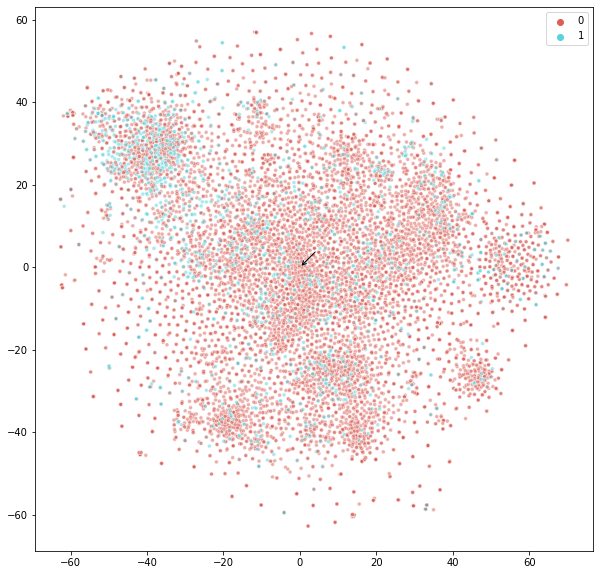

In [966]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], tsne_df[:,1], alpha=0.5, s=15, hue=colors, 
                      palette=sns.color_palette('hls', 2))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(True)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

Plot, colored by week

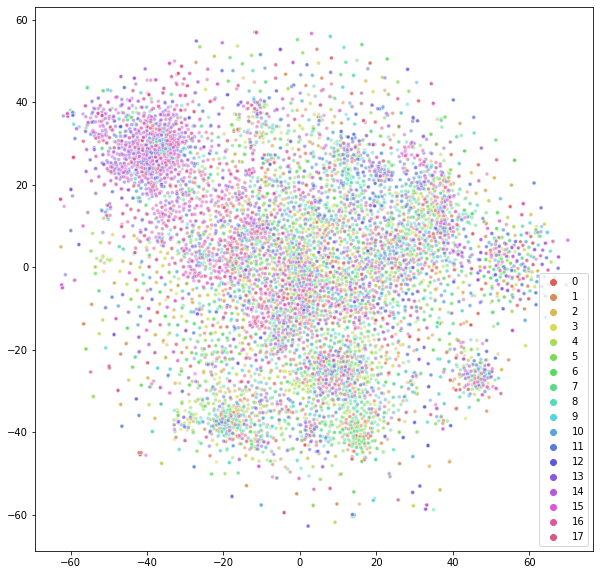

In [968]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], 
                      tsne_df[:,1], 
                      alpha=0.5, 
                      s=15, 
                      hue=colors_by_weeks,
                      palette=sns.color_palette('hls', len(weeks)))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(False)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

Color by months

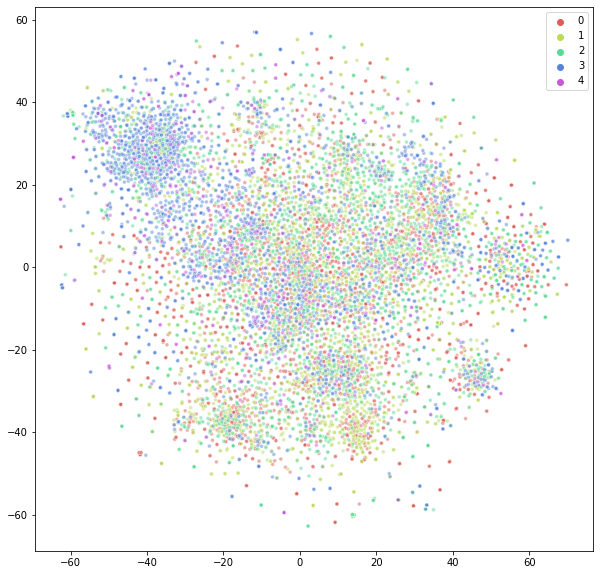

In [971]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], 
                      tsne_df[:,1], 
                      alpha=0.5, 
                      s=15, 
                      hue=colors_by_months,
                      palette=sns.color_palette('hls', len(months)))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(False)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

In [620]:
all_headlines[277]

'Alta and Snowbird are renowned ski destinations but crowded. Instead, try Solitude.'

In [622]:
all_headlines[325]

'It’s time for radical change at the Grammys — and the clock is ticking'

## Doc2vec

Can I plot it with the rest of Google News document vectors?

In [939]:
len(all_headlines)

9939

Tokenize each headline, removing stopwords. 

In [943]:
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(all_headlines) if _d not in stop_words]
len(train_corpus)

9939

Train model.

In [542]:
model_doc2vec = Doc2Vec(vector_size=300,
                        alpha=0.025,
                        min_alpha = 0.001,
                        min_count=1,
                        workers=10, 
                        dm=1,
                        epochs=40)

model_doc2vec.build_vocab(train_corpus)

Train model for 10 epochs.

In [543]:
start = timer()
model_doc2vec.train(train_corpus, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)
model_doc2vec.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Model Saved
Execution time HH:MM:SS: 0:00:23.755177


In [537]:
model_doc2vec[0]

array([ 1.3504637e-02,  8.2566766e-03, -2.1916255e-03,  4.3237326e-03,
       -9.4604604e-03,  1.5311696e-03, -1.2774942e-02, -6.5150219e-03,
       -1.2243640e-03, -1.4054816e-02, -1.3206872e-02, -6.5680663e-03,
        3.9786624e-04,  1.6083424e-03, -3.1921580e-03, -2.8327331e-03,
        2.4701109e-02, -6.5988651e-03,  2.4777565e-02,  1.7686073e-02,
        1.4777459e-02,  2.6327069e-04, -3.0054459e-02, -1.0576738e-02,
        1.0586901e-02,  1.7423746e-03, -5.0879340e-03, -5.7256166e-03,
        1.5045743e-02, -5.4006162e-03, -1.2176604e-02, -1.1682622e-02,
        9.5394859e-03, -1.9388972e-02, -3.3118133e-03, -6.8102687e-05,
        3.7937851e-03,  1.7227162e-02, -3.1893281e-03, -1.3738032e-03,
       -3.0077607e-04, -1.0218359e-02,  1.2085522e-02, -3.3307194e-03,
        1.2321858e-02, -4.2730637e-04,  5.6988602e-03, -3.3569229e-03,
       -1.1657155e-02,  9.3366858e-03,  3.0945492e-04,  2.5784165e-02,
       -1.6956830e-02,  2.9948445e-03, -1.1000807e-02, -6.3609325e-05,
      

Get the documents from the model.

In [515]:
doc_tags = list(model_doc2vec.docvecs.doctags.keys())
docs = model_doc2vec[doc_tags]
len(docs)

4075

In [516]:
docs[0]

array([ 0.07174653,  0.05016864,  0.03845977,  0.02634695, -0.07409763,
        0.02918518, -0.06415798, -0.05565873, -0.0027413 , -0.09055971],
      dtype=float32)

In [517]:
model_doc2vec.docvecs.most_similar(0)

[('3328', 0.9699888825416565),
 ('2767', 0.9683275818824768),
 ('504', 0.9664832353591919),
 ('2206', 0.9641293883323669),
 ('1856', 0.9629613161087036),
 ('2775', 0.9622619152069092),
 ('2449', 0.9612644910812378),
 ('1338', 0.96107417345047),
 ('602', 0.9608083367347717),
 ('267', 0.9546763300895691)]

In [518]:
all_headlines[0]

'House managers, Trump’s legal team spar over rules to guide trial'

In [519]:
all_headlines[3328]

'Chat Transcript: Ways to maintain your mental health during the coronavirus outbreak'

In [10]:
all_headlines[504]

'A guide to local favorites on Freret Street'

In [557]:
model_doc2vec.wv.most_similar('italy')

[('china', 0.9221874475479126),
 ('death', 0.9145364761352539),
 ('toll', 0.9133531451225281),
 ('deaths', 0.9032647609710693),
 (';', 0.9004700779914856),
 ('confirmed', 0.8946788907051086),
 ('cases', 0.8926124572753906),
 ('spike', 0.8825417757034302),
 ('spreads', 0.8822505474090576),
 ('plunge', 0.8802657723426819)]

## Sentiment analysis

In [30]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [16]:
sia = SIA()

In [62]:
for line in df_headsects_unique['headline']:
    pol_score = sia.polarity_scores(line)
    df_headsects_unique['neg'] = pol_score['neg']
    df_headsects_unique['neu'] = pol_score['neu']
    df_headsects_unique['pos'] = pol_score['pos']
    df_headsects_unique['compound'] = pol_score['compound']
    
df_headsects_unique

/home/bkh4324/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bkh4324/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/bkh4324/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,date,link,time,headline,section,neg,neu,pos,compound
1,2019-12-31,https://web.archive.org/web/20191231235831/washingtonpost.com,23:58:31,How black women are fighting for — and winning — space on the bookshelf,podcasts,0.185,0.694,0.121,-0.2732
4,2019-12-31,https://web.archive.org/web/20191231235831/washingtonpost.com,23:58:31,Militia supporters chanting ‘Death to America’ break into U.S. Embassy compound in Baghdad,world,0.185,0.694,0.121,-0.2732
5,2019-12-31,https://web.archive.org/web/20191231235831/washingtonpost.com,23:58:31,Retropolis: ‘Death to America’ chants heard in Baghdad echo the Iran hostage crisis,history,0.185,0.694,0.121,-0.2732
6,2019-12-31,https://web.archive.org/web/20191231235831/washingtonpost.com,23:58:31,"Trump threatens Iran after embassy attack, but is reluctant to get more involved in region",politics,0.185,0.694,0.121,-0.2732
7,2019-12-31,https://web.archive.org/web/20191231235831/washingtonpost.com,23:58:31,Why Iraq is at the center of the dispute between Iran and the United States,world,0.185,0.694,0.121,-0.2732
...,...,...,...,...,...,...,...,...,...
10153,2020-04-11,https://web.archive.org/web/20200411175428/washingtonpost.com,17:54:28,‘Screen time’ has gone from sin to survival tool,technology,0.185,0.694,0.121,-0.2732
10154,2020-04-11,https://web.archive.org/web/20200411175428/washingtonpost.com,17:54:28,Undocumented workers among those hit first — and worst — by the coronavirus shutdown,business,0.185,0.694,0.121,-0.2732
10155,2020-04-11,https://web.archive.org/web/20200411175428/washingtonpost.com,17:54:28,"Pat Stapleton, all-star defenseman for Chicago Blackhawks, dies at 79",local,0.185,0.694,0.121,-0.2732
10156,2020-04-11,https://web.archive.org/web/20200411175428/washingtonpost.com,17:54:28,"Darran Simon, Washington Post journalist, dies at 43",local,0.185,0.694,0.121,-0.2732


In [27]:
df_sentiment = pd.DataFrame.from_records(results)
df_sentiment.head()

,neg,neu,pos,compound,headline
0,0.157,0.629,0.214,0.2263,How black women are fighting for — and winning...
1,0.000,0.805,0.195,0.4404,Militia supporters chanting ‘Death to America’...
2,0.255,0.745,0.000,-0.6249,Retropolis: ‘Death to America’ chants heard in...
3,0.346,0.654,0.000,-0.6542,"Trump threatens Iran after embassy attack, but..."
4,0.146,0.703,0.151,0.0258,Why Iraq is at the center of the dispute betwe...


In [28]:
df_sentiment['label'] = 0
df_sentiment.loc[df_sentiment['compound'] > 0.2, 'label'] = 1
df_sentiment.loc[df_sentiment['compound'] < -0.2, 'label'] = -1
df_sentiment

,neg,neu,pos,compound,headline,label
0,0.157,0.629,0.214,0.2263,How black women are fighting for — and winning...,1
1,0.000,0.805,0.195,0.4404,Militia supporters chanting ‘Death to America’...,1
2,0.255,0.745,0.000,-0.6249,Retropolis: ‘Death to America’ chants heard in...,-1
3,0.346,0.654,0.000,-0.6542,"Trump threatens Iran after embassy attack, but...",-1
4,0.146,0.703,0.151,0.0258,Why Iraq is at the center of the dispute betwe...,0
...,...,...,...,...,...,...
7962,0.310,0.690,0.000,-0.5574,‘Screen time’ has gone from sin to survival tool,-1
7963,0.272,0.728,0.000,-0.6249,Undocumented workers among those hit first — a...,-1
7964,0.000,0.891,0.109,0.0258,"Pat Stapleton, all-star defenseman for Chicago...",0
7965,0.000,1.000,0.000,0.0000,"Darran Simon, Washington Post journalist, dies...",0


Sort by the most positive. Show the 25 most positive headlines. (use pos or compound?)

In [59]:
df_sentiment.sort_values(['pos'], ascending=False).head(25)

,neg,neu,pos,compound,headline,label
2035,0.0,0.309,0.691,0.7717,Peace through strength is back,1
3647,0.0,0.333,0.667,0.2500,TRUMP ACQUITTED,1
1460,0.0,0.337,0.663,0.8957,Splurge-worthy and great bargain sparkling wines to celebrate the season,1
3507,0.0,0.342,0.658,0.8271,Experts pick the Super Bowl winner,1
6642,0.0,0.366,0.634,0.6369,Powerful union endorses Joe Biden,1
4413,0.0,0.377,0.623,0.5106,Trust and consequences,1
3363,0.0,0.382,0.618,0.8442,The best moments in Super Bowl history,1
398,0.0,0.390,0.610,0.8555,6 festive cocktail recipes for your merriest Christmas party ever,1
6252,0.0,0.390,0.610,0.8555,Friends and family: Sanders’ campaign fueled by passionate supporters,1
5195,0.0,0.390,0.610,0.7397,What’s so important about Super Tuesday?,1


Sort by the most negative. Show the 25 most negative headlines.

In [60]:
df_sentiment.sort_values(['neg'], ascending=False).head(25)

,neg,neu,pos,compound,headline,label
109,0.792,0.208,0.0,-0.8225,Venezuela’s collapse: Enduring a catastrophe,-1
5746,0.708,0.292,0.0,-0.8658,Oil price war threatens widespread collateral damage,-1
6809,0.697,0.303,0.0,-0.7845,Fear and anger during a pandemic,-1
1851,0.688,0.312,0.0,-0.8316,Stampede kills dozens at Iranian general’s funeral,-1
1930,0.675,0.325,0.0,-0.8860,Cancer death rate posts biggest one-year drop ever,-1
3833,0.667,0.333,0.0,-0.9325,"Ban on sales of assault weapons advances in Virginia, stirring anger",-1
7478,0.661,0.339,0.0,-0.5994,Death without ritual,-1
1112,0.661,0.339,0.0,-0.5994,The infinity war,-1
3482,0.653,0.347,0.0,-0.8555,"London police: 2 injured, suspect killed in ‘terrorist-related’ stabbing",-1
185,0.647,0.353,0.0,-0.6705,Suspects arrested in Denny’s shooting,-1


Examples of positive headlines.

In [29]:
list(df_sentiment[df_sentiment['label'] == 1].headline)[:10]

['How black women are fighting for — and winning — space on the bookshelf',
 'Militia supporters chanting ‘Death to America’ break into U.S. Embassy compound in Baghdad',
 'The calendar says we’re moving on from the 2010s. It sure doesn’t feel that way.',
 'More good news that happened in 2019',
 'Iran just outplayed the United States — again',
 'Dwyane Wade and Gabrielle Union’s simple, open-armed act of parental love',
 'If you love books, you owe a debt to Sonny Mehta',
 'Countdown specials: Where to watch and who has the best celebrity guests',
 'Some of the world’s tastiest New Year’s good luck traditions',
 'Ala. police chief apologizes after two officers pose with ‘homeless quilt’ made from confiscated signs']

Examples of negative headlines.

In [30]:
list(df_sentiment[df_sentiment['label'] == -1].headline)[:10]

['Retropolis: ‘Death to America’ chants heard in Baghdad echo the Iran hostage crisis',
 'Trump threatens Iran after embassy attack, but is reluctant to get more involved in region',
 'Trump Organization fires more undocumented workers, a year after its use of illegal labor was revealed',
 'Thousands forced to take refuge on Australian beach as deadly wildfires close in',
 'In the past decade, at least 554 journalists have been killed worldwide',
 'Democrats sharpen their differences as Iowa caucuses loom',
 'How the storming of the U.S. Embassy in Baghdad compares to attacks at other American diplomatic facilities',
 'These 3 pro-Iran militia leaders are provoking protesters at the U.S. Embassy in Baghdad',
 'A country with a growing death row reconsiders its future with capital punishment',
 'Prison guard trainees were photographed giving a Nazi salute. The entire class was fired.']

Total positives and negatives.

In [31]:
df_sentiment.label.value_counts(normalize=True) * 100

 0    42.876867
-1    31.655579
 1    25.467554
Name: label, dtype: float64

<IPython.core.display.Javascript object>


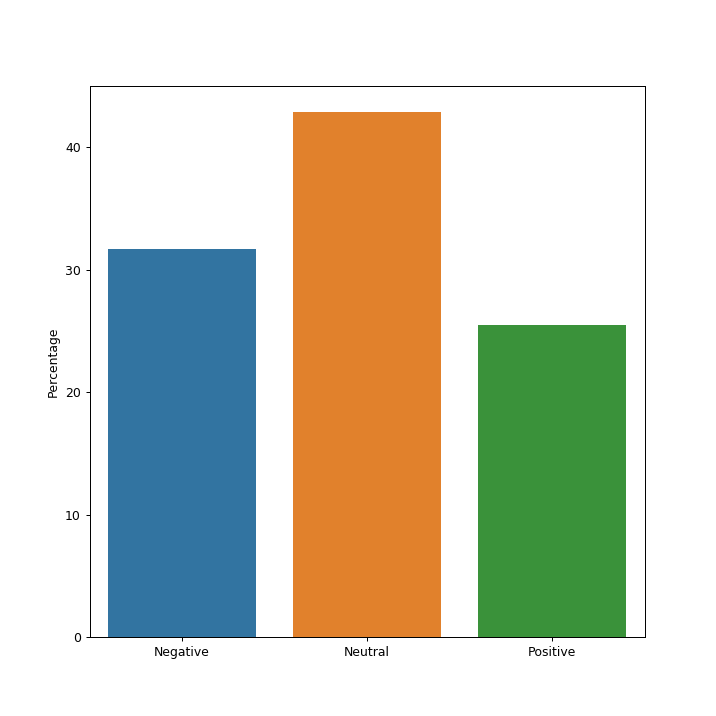

In [32]:
fig, ax = plt.subplots(figsize=(8,8))

counts = df_sentiment.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel('Percentage')

plt.show()

The large number of neutral headlines is due to two main reasons:

- The assumption that we made where headlines with compound value between 0.2 and -0.2 are considered neutral. The higher the margin, the larger the number of neutral headlines.
- We used general lexicon to categorize news. 

Another interesting observation is the number of negative headlines, which could be attributed to the media's behavior, such as the exaggeration of titles for clickbait. Another possibility is that our analyzer produced a lot of false negatives.

Get the most common words in the positive headlines:

In [38]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [39]:
pos_lines = list(df_sentiment[df_sentiment.label == 1].headline)
pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)
pos_freq.most_common(20)

[('trump', 233),
 ('coronavirus', 150),
 ('new', 115),
 ('best', 97),
 ('help', 83),
 ('u', 80),
 ('like', 72),
 ('dies', 70),
 ('says', 55),
 ('one', 54),
 ('win', 54),
 ('super', 50),
 ('c', 48),
 ('court', 44),
 ('year', 41),
 ('carolyn', 41),
 ('hax', 41),
 ('democrats', 41),
 ('make', 40),
 ('time', 39)]

Interesting that "coronavirus," "covid," and "trump" are in the list. As we see in the negative word section, a lot of the same words appear, so it's not definitive. 

We could compare which news publication has the most positive headlines.